In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from scipy.stats import skew
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [2]:
# load data
train = pd.read_csv('../data/train.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

In [3]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Exploratory EDA

In [4]:
train.shape

(1460, 80)

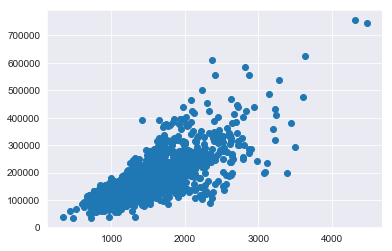

In [7]:
plt.scatter(train['GrLivArea'], train['SalePrice'])

In [8]:
# drop outliers
print(train[train['GrLivArea'] >= 4000])

outliers = train[(train['GrLivArea'] >= 4000) & (train['SalePrice'] < 210000)].index

train.drop(outliers, inplace=True)

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
692           60       RL        104.0    21535   Pave   NaN      IR1   
1183          60       RL        160.0    15623   Pave   NaN      IR1   

     LandContour Utilities LotConfig    ...     PoolArea PoolQC  Fence  \
Id                                      ...                              
692          Lvl    AllPub    Corner    ...            0    NaN    NaN   
1183         Lvl    AllPub    Corner    ...          555     Ex  MnPrv   

     MiscFeature MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                                           
692          NaN       0      1    2007        WD         Normal     755000  
1183         NaN       0      7    2007        WD        Abnorml     745000  

[2 rows x 80 columns]


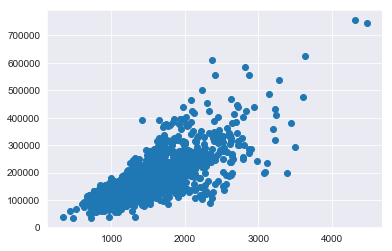

In [9]:
plt.scatter(train['GrLivArea'], train['SalePrice'])

In [10]:
# missing data
missing = train.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [11]:
#For most columns (as seen from the documentation), NA means that the  house does not have that feature
#We can replace NA with the word 'No', to indicate the feature doesn't exist for this house
#Define function to do this for multiple column names

def ConvertNaToNone(df, varlist):
    amescopy = df.copy()
    for var in varlist:
        series = train[var]
        series[series.isna()] = 'None'
        amescopy[var] = series
    return amescopy

In [12]:
ames = ConvertNaToNone(train, ['PoolQC', 'MiscFeature','Alley', 'Fence', 'FireplaceQu', 
                                      'GarageYrBlt', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 
                                      'GarageType', 'GarageFinish', 'GarageQual', 'BsmtCond', 'BsmtQual', 
                                      'BsmtFinType1', 'MasVnrType'])

In [13]:
null = ames.isnull().sum()
null[null > 0].sort_values(ascending=False)

LotFrontage    259
MasVnrArea       8
Electrical       1
dtype: int64

In [14]:
#For the one missing 'Electrical' entry, replace with the most common category
print(ames['Electrical'].value_counts())
ames.loc[ames['Electrical'].isna(),'Electrical'] = 'SBrkr'
print(ames['Electrical'].value_counts())

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
SBrkr    1333
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64


In [15]:
#For the two numerical entries (LotFrontage, MasVnrArea), replace with random sample of the non-NA values
np.random.seed(0)

ames.loc[ames['LotFrontage'].isna(), 'LotFrontage'] = np.random.choice(ames['LotFrontage'].dropna(), size=259, replace=True)
ames.loc[ames['MasVnrArea'].isna(), 'MasVnrArea'] = np.random.choice(ames['MasVnrArea'].dropna(), size=8, replace=True)

In [16]:
PureCategorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
                  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'MasVnrType', 'Heating', 'CentralAir', 'Electrical',
                  'GarageType', 'SaleType','SaleCondition']
QuesCategorical = ['LotShape', 'Utilities']
OrdCategorical = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                 'PavedDrive', 'PoolQC','Fence']
JointFeatures = ['Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd']
Numerical = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtScore', 'TotalBsmtSF', 'TotalSF',
            'PctLowQual', 'AboveGroundPct', 'TotalBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
            'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
            'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
len(PureCategorical) + len(QuesCategorical) + len(OrdCategorical) + len(JointFeatures) + len(Numerical)

71

In [17]:
#Fix index 333, BsmtFinType2 to 'Unf' as it should be
ames.loc[333,'BsmtFinType2']='Unf'

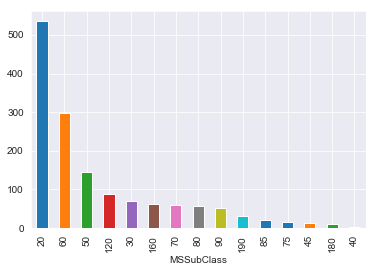

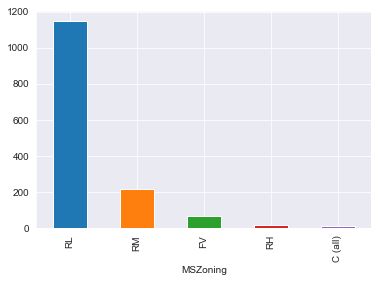

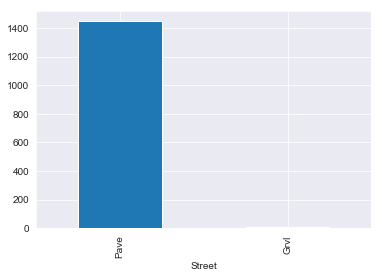

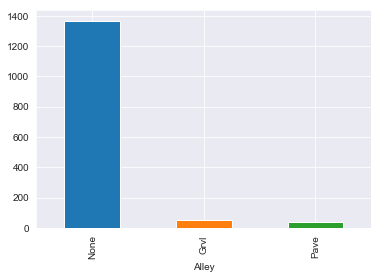

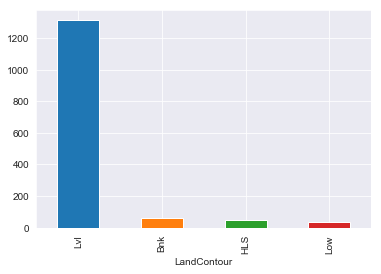

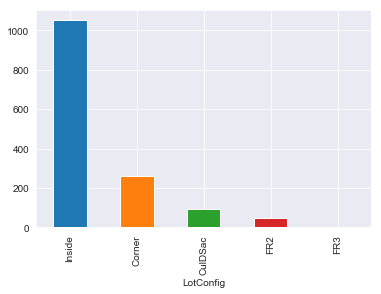

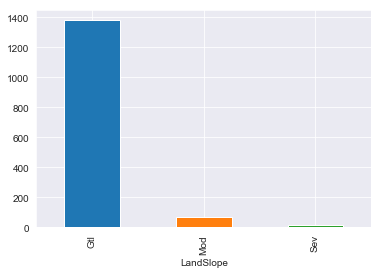

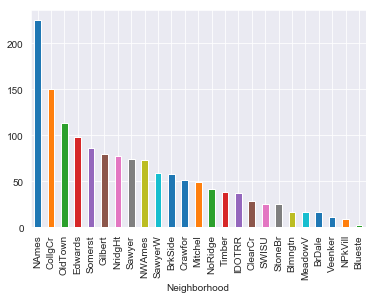

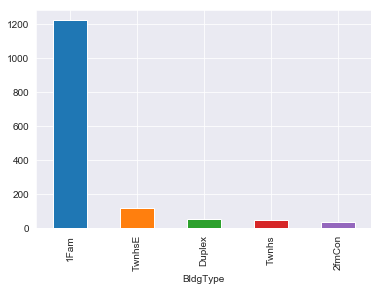

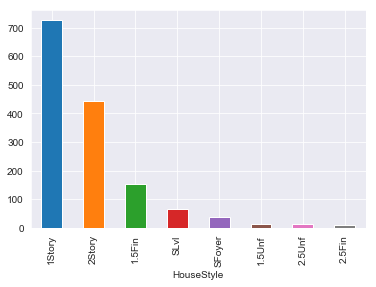

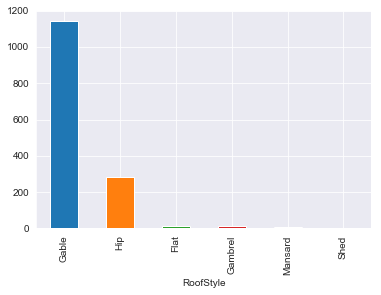

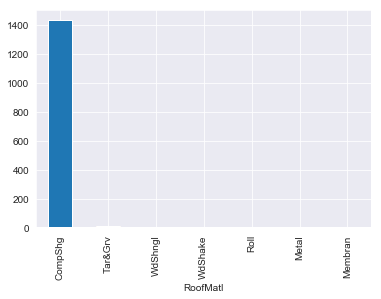

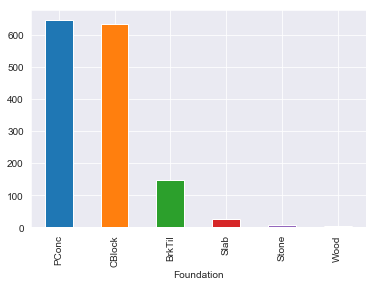

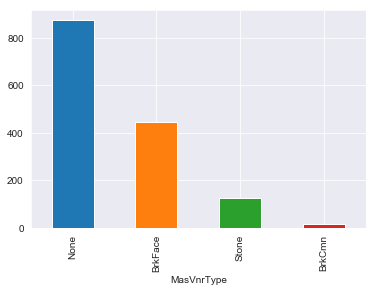

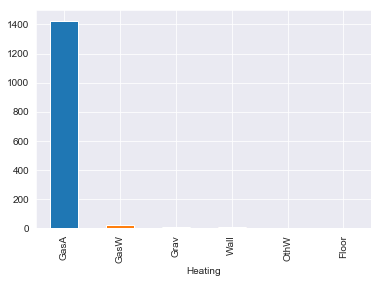

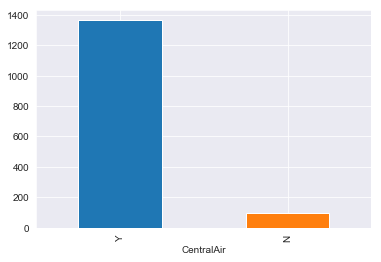

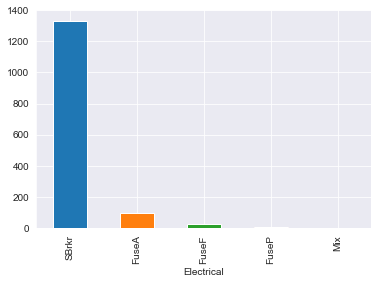

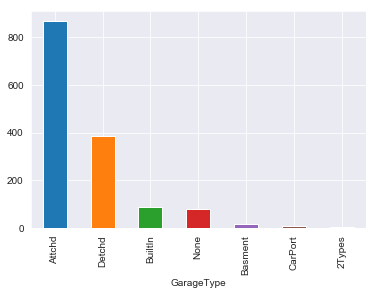

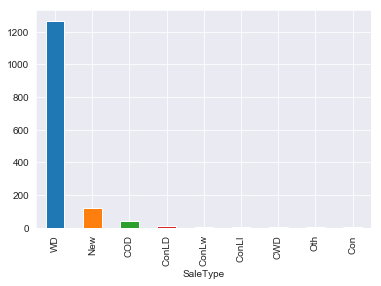

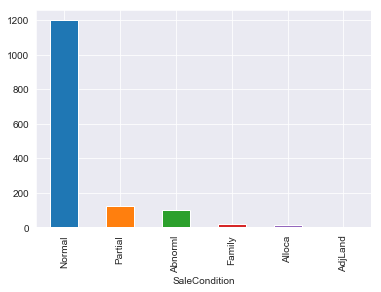

In [18]:
#Visualize Categorical Data
for feature in PureCategorical:
    class_count = ames.groupby(feature).size().sort_values(ascending=False).plot(kind='bar')
    plt.show()

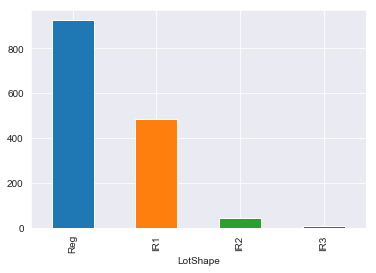

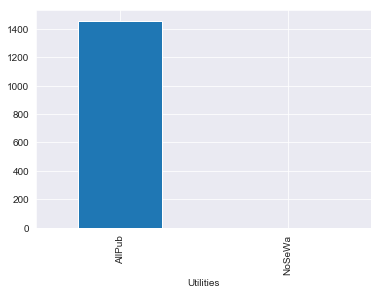

In [19]:
for feature in QuesCategorical:
    class_count = ames.groupby(feature).size().sort_values(ascending=False).plot(kind='bar')
    plt.show()

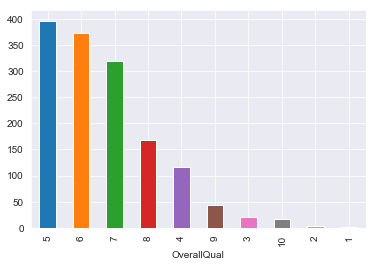

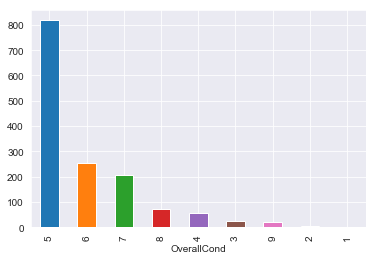

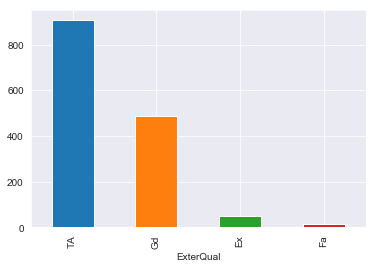

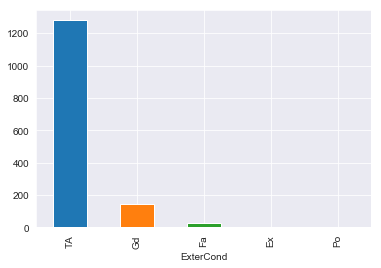

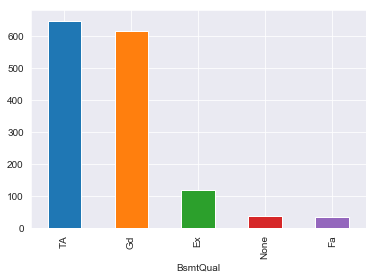

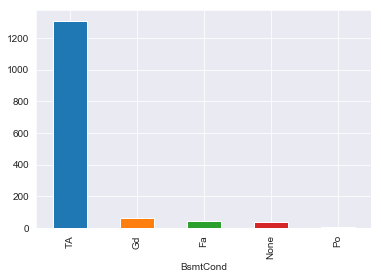

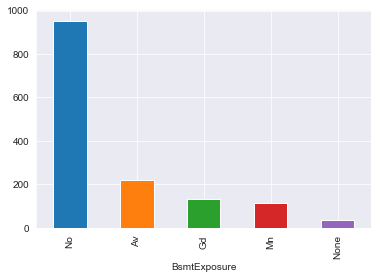

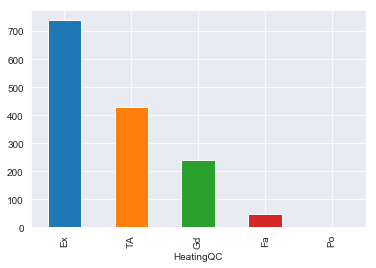

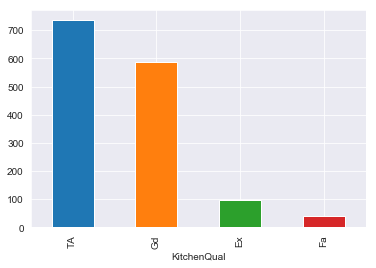

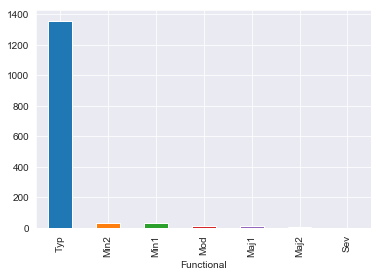

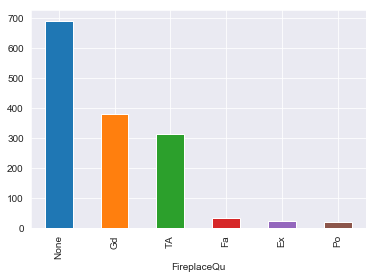

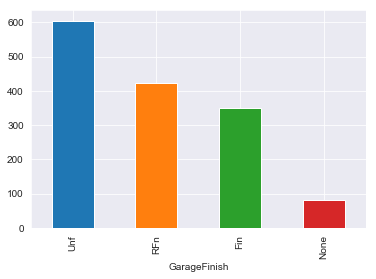

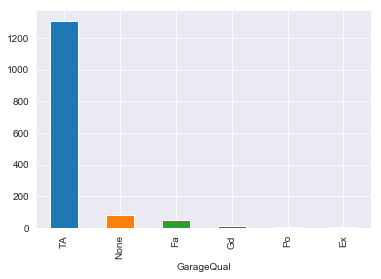

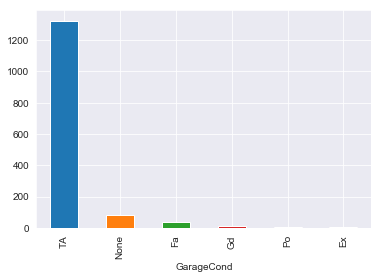

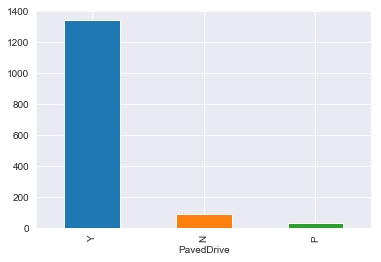

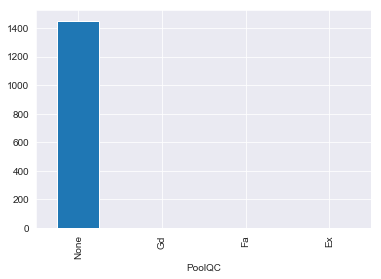

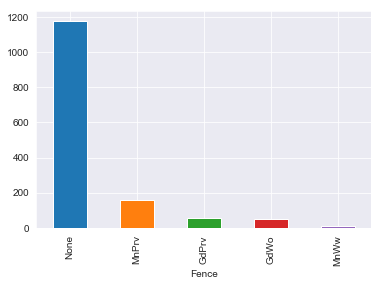

In [20]:
for feature in OrdCategorical:
    class_count = ames.groupby(feature).size().sort_values(ascending=False).plot(kind='bar')
    plt.show()    

most features are not normally distributed.

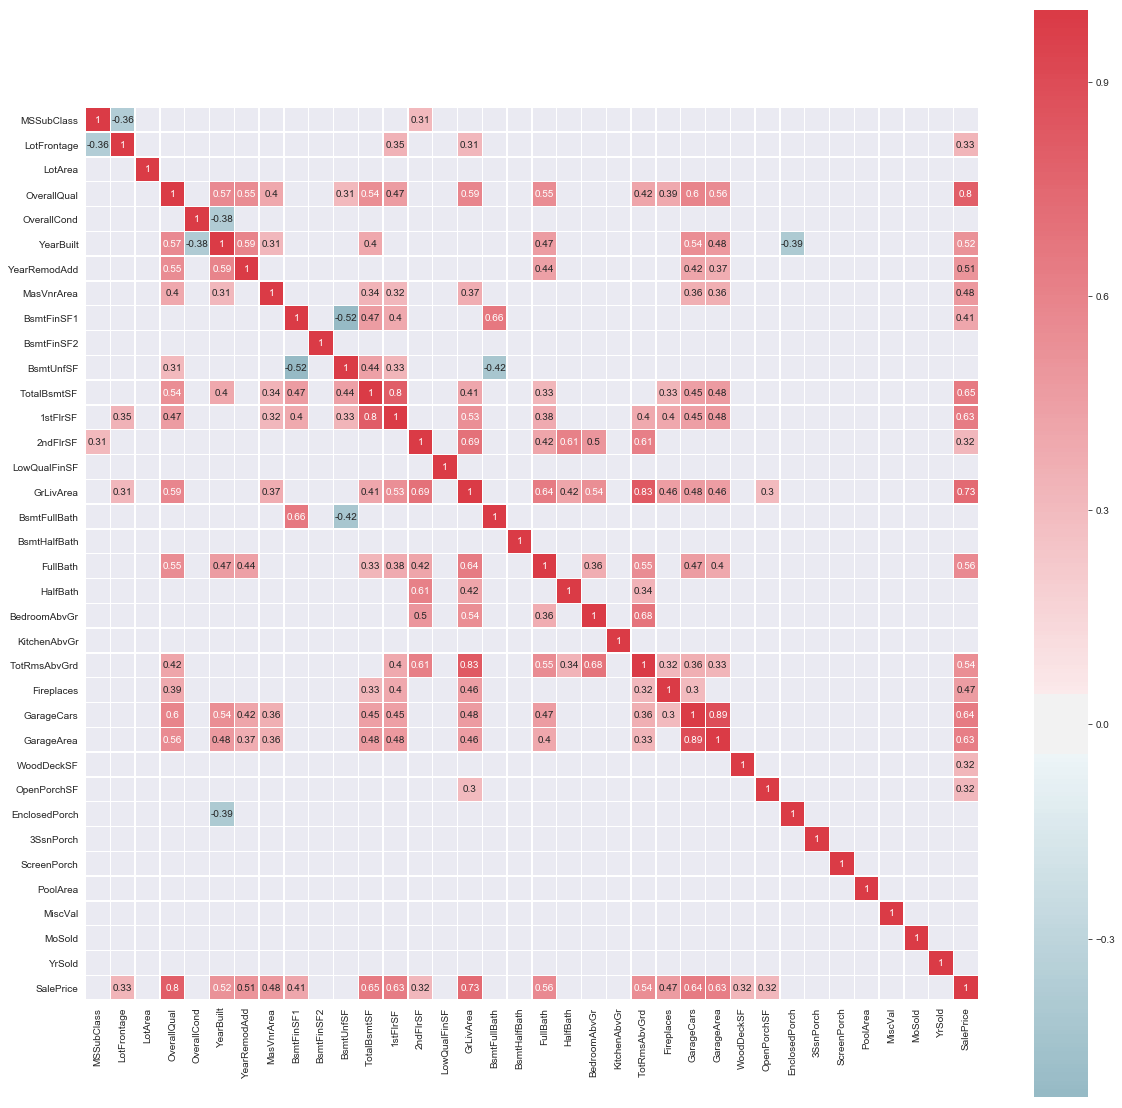

In [21]:
correlation = ames.corr(method='pearson')
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation[(correlation > 0.3)| (correlation < -0.3)], cmap=cmap,
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, 
            center=0, annot=True,
            square=True, linewidths=.5, annot_kws={"size": 10})

# sns.heatmap(, cbar_kws={"shrink": .5},
#             center=0, square=True,
#             annot=True, linewidths=.5, annot_kws={"size": 8})

In [22]:
# check for skewness of data
skew_ = pd.DataFrame(ames.skew(), columns=["skew"])
skew_[(skew_>1) | (skew_<-1)].dropna()

,skew
MSSubClass,1.407011
LotFrontage,1.469993
LotArea,12.573925
MasVnrArea,2.688945
BsmtFinSF2,4.251925
LowQualFinSF,9.004955
GrLivArea,1.010992
BsmtHalfBath,4.100114
KitchenAbvGr,4.484883
WoodDeckSF,1.545805


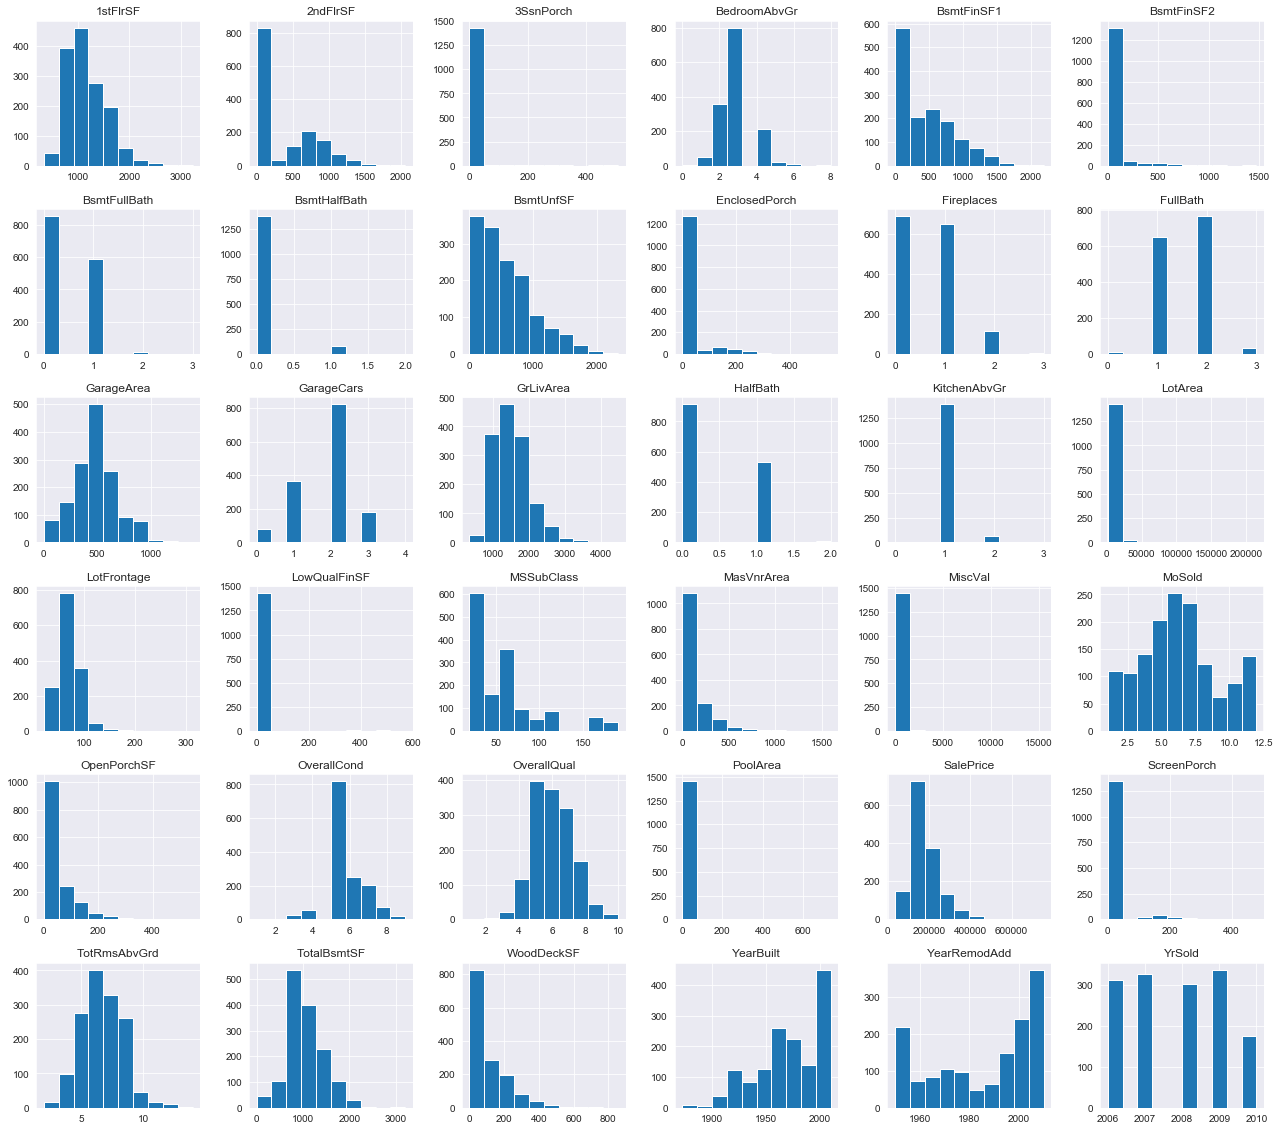

In [23]:
# histogram overview of data
overview = ames.hist(figsize=(22,20))

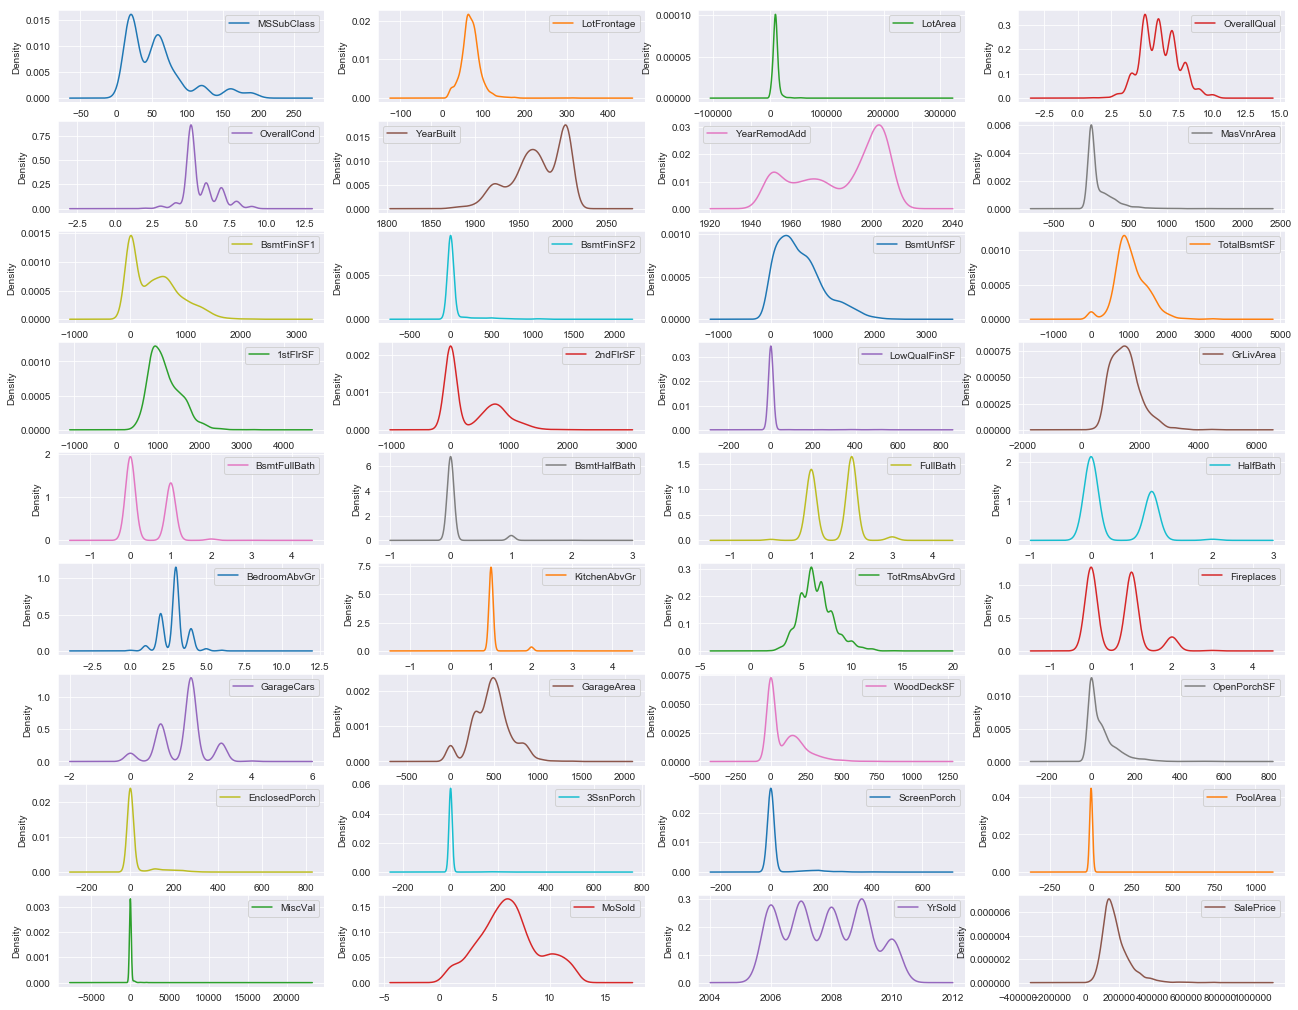

In [24]:
# density overview
density = ames.plot(kind='density', subplots=True, layout=(10, 4), sharex=False, figsize=(22,20))

In [1]:
# # scatter overview of data
# feature = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtScore', 'TotalBsmtSF', 'TotalSF',
#             'PctLowQual', 'AboveGroundPct', 'TotalBath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#             'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
#             'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
# # density overview
# scatter = ames.plot(x = feature,  y ='SalePrice', kind='scatter', subplots=True, layout=(10, 4), sharey=True, figsize=(22,20))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from scipy.stats import skew
import seaborn as sns
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')
ames = pd.read_csv('../data/AmesDummiesOrdinal.csv', index_col=0)

In [6]:
ames.head()

,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,...,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold_Autumn,MoSold_Spring,MoSold_Winter
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,196.0,856,0,3,1,8,0,2,...,1,3,4,4,3,1,1,0,0,1
2,80.0,9600,0.0,1262,0,3,1,6,1,2,...,4,3,4,4,3,1,1,0,1,0
3,68.0,11250,162.0,920,0,3,1,6,1,2,...,4,3,4,4,3,1,1,1,0,0
4,60.0,9550,0.0,756,0,3,1,7,1,3,...,5,2,4,4,3,1,1,0,0,1
5,84.0,14260,350.0,1145,0,4,1,9,1,3,...,4,3,4,4,3,1,1,0,0,1


In [52]:
xgbFeat = pd.read_csv('../data/xgbFeatures.csv')
xgbCoef = pd.read_csv('../data/xgbCoefsDF.csv')

In [55]:
xgbFeat.head()

,0,1
0,TotalSF,0.087295
1,TotalBsmtSF,0.071737
2,LotArea,0.066984
3,GarageArea,0.044944
4,LotFrontage,0.043215


In [56]:
xgbCoef.head()

,Unnamed: 0,Linear,Linear.1,Linear.2,Linear.3,Linear.4
0,TotalSF,67.854780,64.603031,59.992675,54.562877,55.799761
1,TotalBsmtSF,26.957640,28.115364,30.751234,27.974693,27.303048
2,LotArea,0.636898,0.684094,0.579194,0.658654,0.641095
3,GarageArea,18.710827,3.789451,8.813419,15.558360,21.221892
4,LotFrontage,173.705636,169.542763,138.800265,123.722421,173.800510


In [57]:
rfFeat = pd.read_csv('../data/rfFeatures.csv')
rfCoef = pd.read_csv('../data/rfCoefsDF.csv')

In [58]:
lst = [rfFeat, xgbFeat]
for df in lst:
    df.columns = ['Feature','Score']

In [59]:
rfFeat.head()

,Feature,Score
0,OverallQual,0.650761
1,TotalSF,0.140105
2,TotalBsmtSF,0.062907
3,BsmtScore,0.022469
4,TotalBath,0.018086


In [98]:
def plot_importance(data):
    impt = data[::-1]
    plt.figure(figsize=(9,12))
    plt.title('Boosted Feature Selection')
    plt.barh(impt['Feature'], impt['Score'], align='center')
    plt.xlabel('Relative Importance')
    plt.ylabel('Feature')
    plt.show()

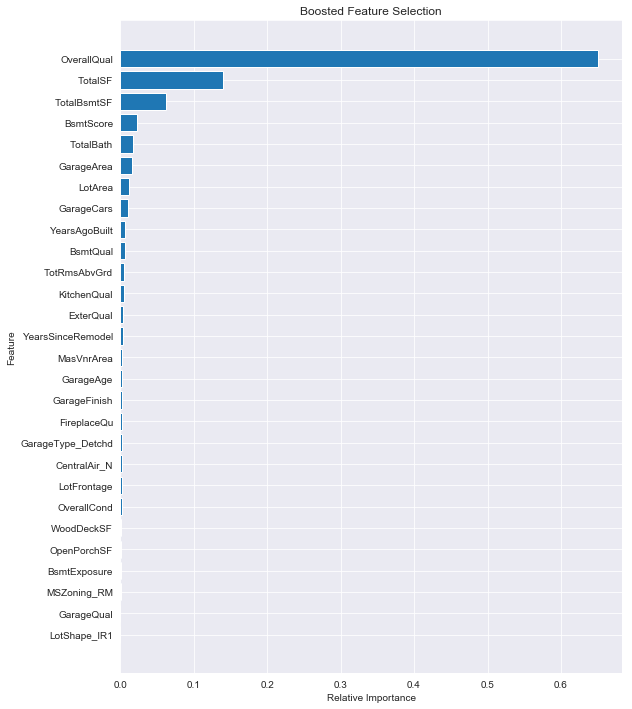

In [99]:
plot_importance(rfFeat)

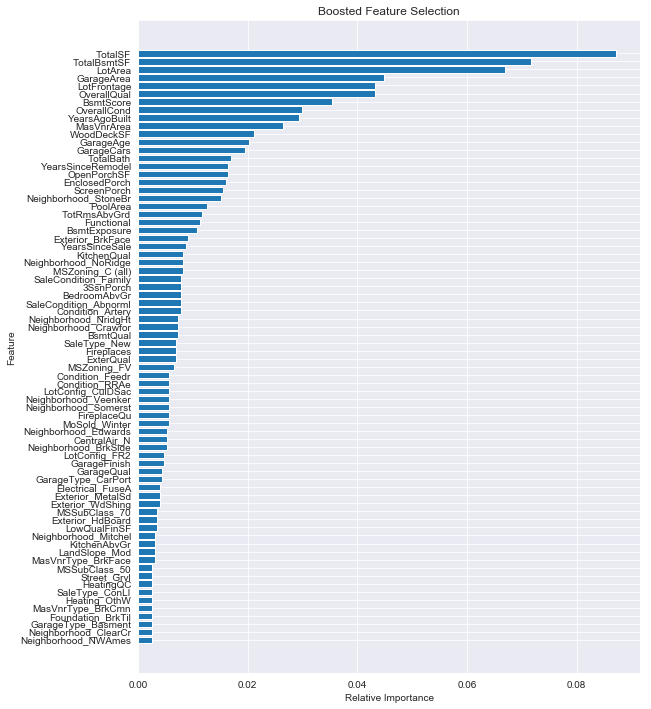

In [100]:
plot_importance(xgbFeat)

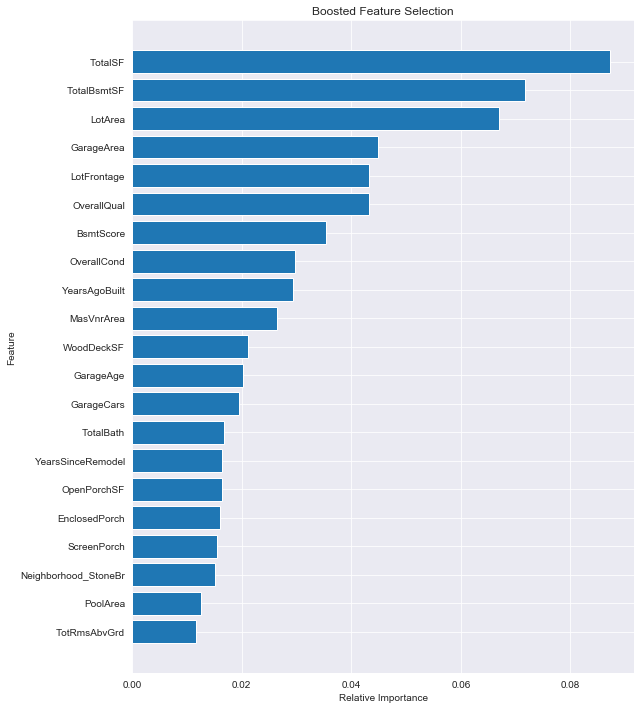

In [102]:
plot_importance(xgbFeat[:21])

In [70]:
indices

,Feature,Score
27,LotShape_IR1,0.000506
26,GarageQual,0.000576
25,MSZoning_RM,0.001143
24,BsmtExposure,0.001321
23,OpenPorchSF,0.001615
22,WoodDeckSF,0.001619
21,OverallCond,0.002043
20,LotFrontage,0.002155
19,CentralAir_N,0.002546
18,GarageType_Detchd,0.002693
